In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
#from desc.magnetic_fields._current_potential import run_regcoil

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from data_comp import iso_coords_interp, data_calc

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory

In [3]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

eq = eq_QA    
###
surf_winding = load("iso_coords/surf.h5")

In [4]:
surf_winding.NFP

3

In [5]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 150, NFP = surf_winding.NFP)
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid)
name = 'iso_coords/'

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [6]:
sdata = iso_coords_interp(name, sdata, sgrid, surf_winding)

G = np.load("iso_coords/G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

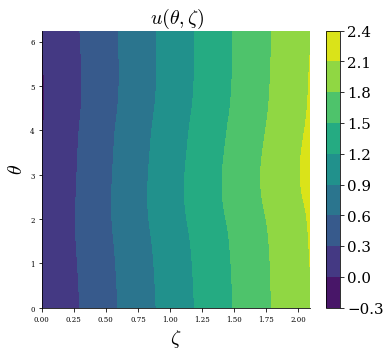

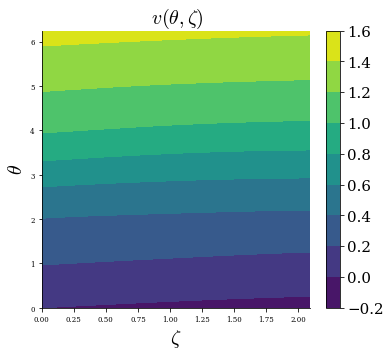

In [7]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

In [8]:
sMv = jnp.asarray([15,])
sNv = jnp.asarray([15,])

In [9]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [10]:
w, w2pol, w1pol, w2tor, w1tor, l, l_u, l_v, e_u, e_v = data_calc(sMv[0],sNv[0],eps,sdata,surf_winding)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

In [11]:
jnp.save('/scratch/gpfs/fcastro/w.npy',w)
jnp.save('/scratch/gpfs/fcastro/w2pol.npy',w2pol)
jnp.save('/scratch/gpfs/fcastro/w1pol.npy',w1pol)
jnp.save('/scratch/gpfs/fcastro/w2tor.npy',w2tor)
jnp.save('/scratch/gpfs/fcastro/w1tor.npy',w1tor)
jnp.save('/scratch/gpfs/fcastro/l.npy',l)
jnp.save('/scratch/gpfs/fcastro/l_u.npy',l_u)
jnp.save('/scratch/gpfs/fcastro/l_v.npy',l_v)
jnp.save('/scratch/gpfs/fcastro/e_u.npy',e_u)
jnp.save('/scratch/gpfs/fcastro/e_v.npy',e_v)
jnp.save('/scratch/gpfs/fcastro/K_sec.npy',K_sec)
jnp.save('/scratch/gpfs/fcastro/K_sv.npy',K_sv)
jnp.save('/scratch/gpfs/fcastro/du.npy',sdata["du"])
jnp.save('/scratch/gpfs/fcastro/dv.npy',sdata["dv"])

jnp.save('/scratch/gpfs/fcastro/jac_surf.npy',sdata["|e_theta x e_zeta|"])
jnp.save('/scratch/gpfs/fcastro/x_surf.npy',xyz2rpz(sdata["x"]))

In [12]:
grid_M = 10
grid_N = 10

egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

B_sec = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2]))

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [13]:
jnp.save('/scratch/gpfs/fcastro/rhs.npy',rhs)